## Imports

In [1]:
import sys
sys.path.insert(0, '../')
from armadl import ARMADL

import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm
import pandas as pd
import sklearn.metrics as skm
import warnings
warnings.filterwarnings('ignore')


from random import sample, choice
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

plt.rc('figure', figsize=(16,12))

#### Loading UCI's Air Quality dataset

In [2]:
dataset = pd.read_csv('AirQualityUCI/AirQualityUCI.csv', sep=';')

In [3]:
dataset.shape

(9471, 17)

In [4]:
dataset.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [5]:
dataset.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

In [6]:
dataset.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [7]:
num_cols = dataset.columns[2:]

In [8]:
num_cols

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [9]:
col_types = dataset[num_cols].dtypes

In [10]:
for col in num_cols:
    if col_types[col] == 'object':
        dataset[col] = dataset[col].apply(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

In [11]:
dataset.dtypes

Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

In [12]:
dataset.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [14]:
dataset = dataset.dropna().reset_index(drop=True)
#dataset.interpolate(limit_direction='both')

## EDA

In [15]:
dataset.shape

(9357, 15)

<AxesSubplot:>

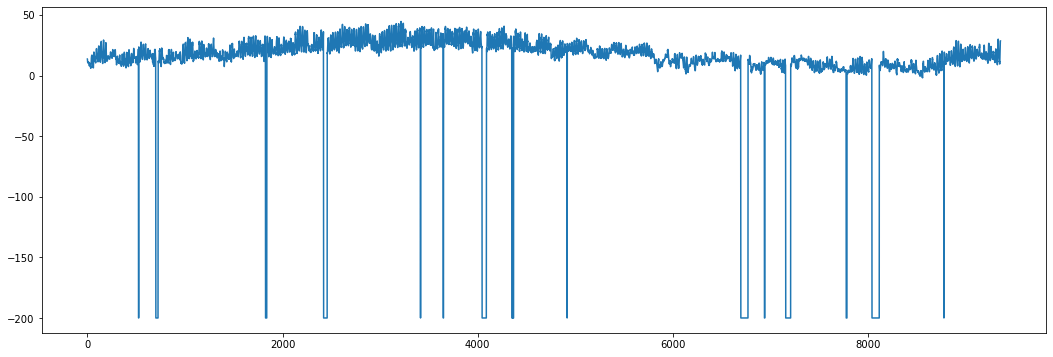

In [16]:
dataset['T'].plot(figsize=(18,6))

In [17]:
dataset[dataset['T']==-200].head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
524,01/04/2004,14.00.00,1.7,-200.0,222.0,-200.0,-200.0,99.0,-200.0,72.0,-200.0,-200.0,-200.0,-200.0,-200.0
525,01/04/2004,15.00.00,1.9,-200.0,197.0,-200.0,-200.0,108.0,-200.0,81.0,-200.0,-200.0,-200.0,-200.0,-200.0
526,01/04/2004,16.00.00,2.3,-200.0,319.0,-200.0,-200.0,131.0,-200.0,93.0,-200.0,-200.0,-200.0,-200.0,-200.0
701,08/04/2004,23.00.00,2.0,-200.0,137.0,-200.0,-200.0,129.0,-200.0,106.0,-200.0,-200.0,-200.0,-200.0,-200.0
702,09/04/2004,00.00.00,2.4,-200.0,189.0,-200.0,-200.0,154.0,-200.0,109.0,-200.0,-200.0,-200.0,-200.0,-200.0


In [18]:
dataset = dataset.replace(-200, np.nan)

In [19]:
dataset = dataset.interpolate(limit_direction='both')

<AxesSubplot:>

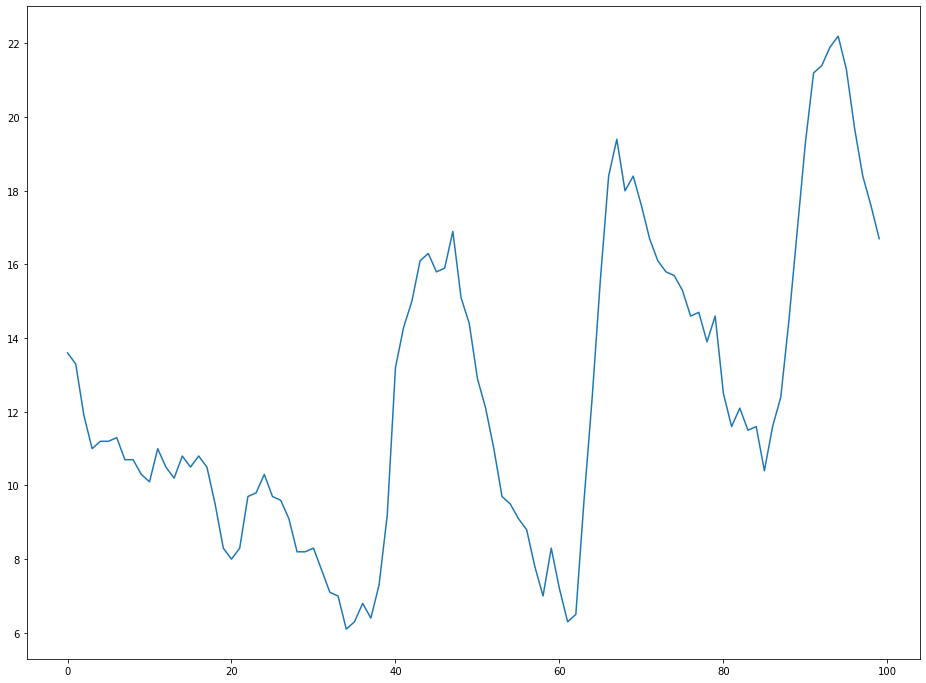

In [20]:
dataset['T'][:100].plot()

#### Seasonal decomposition using STL

In [21]:
stl = STL(dataset['T'], period=24)

In [22]:
stlfit = stl.fit()

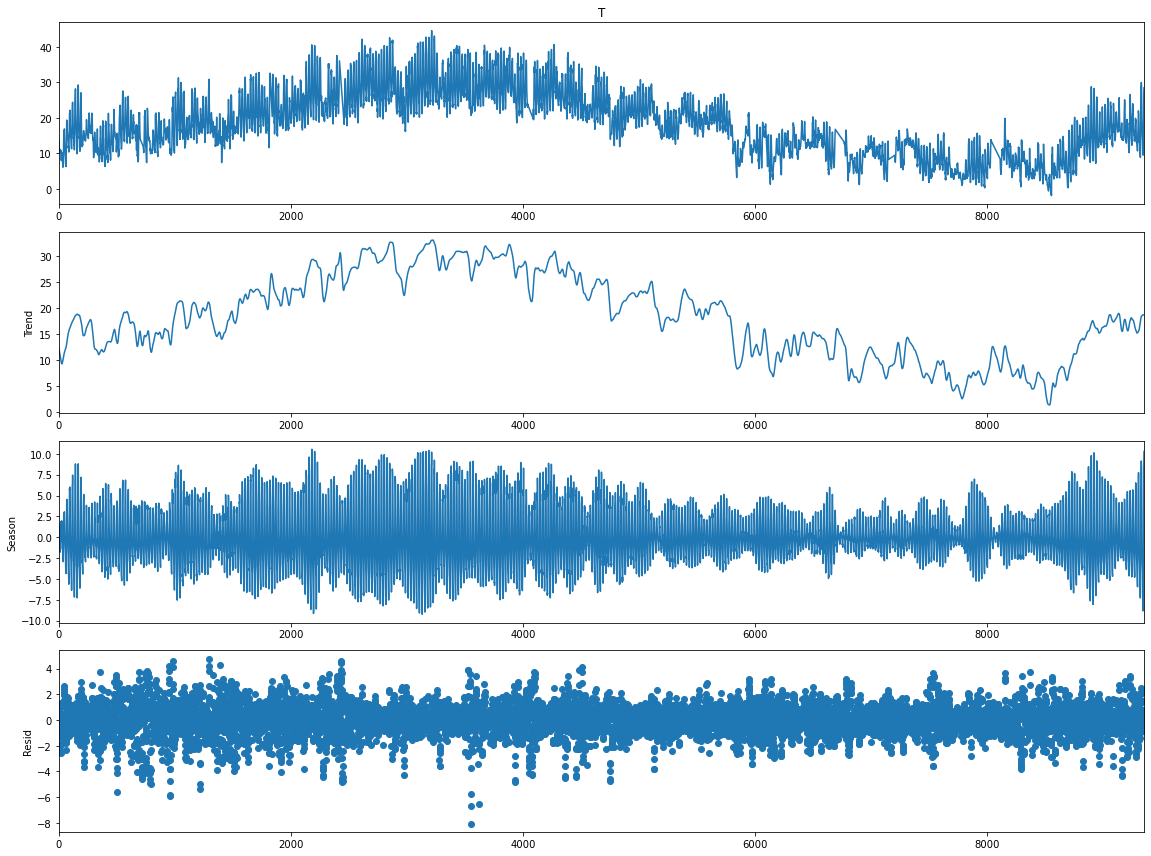

In [23]:
stlfit.plot()
plt.show()

In [24]:
# sres = seasonal_decompose(dataset['T'], period=53)
# sres.plot()
# plt.show()

#### Stationarity test and ACF and PACF analyses

In [25]:
kpss_res = kpss(dataset['T'], nlags='auto', regression='c')
adf_res = adfuller(dataset['T'],regression='c')
print(kpss_res[1], adf_res[1])
sr_diff = dataset['T']-dataset['T'].shift(1)
kpss_res = kpss(sr_diff.dropna(), nlags='auto', regression='c')
adf_res = adfuller(sr_diff.dropna(), regression='c')
print(kpss_res[1], adf_res[1])

0.01 0.027037700591114606
0.1 0.0


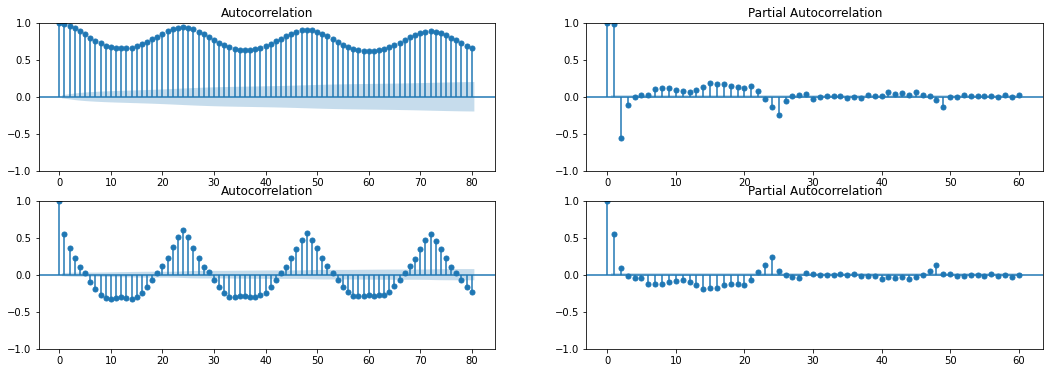

In [26]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(18)
fig.set_figheight(6)
plot_acf(dataset['T'], lags=80, ax=axes[0,0])
plot_pacf(dataset['T'], lags=60, ax=axes[0,1])
plot_acf(sr_diff.interpolate(limit_direction='both'), lags=80, ax=axes[1,0])
plot_pacf(sr_diff.interpolate(limit_direction='both'), lags=60, ax=axes[1,1])
plt.show()

## ARMADL test
Here the first four "seasons" from the data are chosen (weekly data, ~52 weeks per year) for train and test.

In [27]:
#dl_param=2 #{'exog1':[1,2], 'exog2':2}
dl_param='GC'
single_lag = False

In [28]:
num_cols[:3]

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)'], dtype='object')

In [29]:
#exog = None
#exog = dataset[['CO(GT)', 'PT08.S1(CO)']][:8*24]
exog = dataset[num_cols[:3]][:16*24]

In [30]:
mdl = ARMADL(dataset['T'][:16*24], 
             exog=exog, 
             dl_param=dl_param, single_lag=single_lag)

#### Important!
ARMADL primarily works as a wrapper for the pmdarima's model selection function named *auto_arima*. Therefore, all the auto_arima() function parameters should be provided. Details on auto_arima() can be found here: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [31]:
auto_arima_params = dict(start_p=0, start_q=0, with_intercept=True,
                       test='adf', trace=True, stepwise=False, seasonal=True, out_of_sample_size=24,
                       scoring='mse', m=24, maxiter=5)

In [32]:
mdl.exog.head()

,CO(GT),CO(GT)_1,PT08.S1(CO),PT08.S1(CO)_1,NMHC(GT),NMHC(GT)_1
0,2.6,0.0,1360.0,0.0,150.0,0.0
1,2.0,2.6,1292.0,1360.0,112.0,150.0
2,2.2,2.0,1402.0,1292.0,88.0,112.0
3,2.2,2.2,1376.0,1402.0,80.0,88.0
4,1.6,2.2,1272.0,1376.0,51.0,80.0


In [33]:
mdl.dl_param

{'CO(GT)': 1, 'PT08.S1(CO)': 1, 'NMHC(GT)': 1}

#### ARMADL model selection where distributed lags are included.

In [34]:
res = mdl.model_selection(strategy='split', 
                          train_size=12*24, 
                          get_results=True, 
                          use_pretrained=False, 
                          store_model=False, 
                          model_path='AirQuality_model_L1.pckl',
                          **auto_arima_params)

 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1661.574, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=1554.099, Time=0.34 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=1520.482, Time=0.30 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=1524.814, Time=0.38 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=1518.750, Time=2.15 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=1524.797, Time=1.93 sec
 ARIMA(0,0,0)(2,0,2)[24] intercept   : AIC=1572.861, Time=2.49 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=1655.860, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1531.123, Time=0.38 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=1490.314, Time=0.33 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=1495.414, Time=0.43 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(0,0,1)(2

In [35]:
mdl.exog.shape

(384, 6)

In [36]:
train_endog, train_preds, test_endog, test_preds = res

#### Calculating MAPE

In [37]:
skm.mean_absolute_percentage_error(train_endog, train_preds)

0.35843166567128537

In [38]:
skm.mean_absolute_percentage_error(test_endog, test_preds)

0.16428959131794243

#### The fitted model is stored in a list and can be retrieved.

In [39]:
fit_res = mdl.fit_res[0]

In [40]:
fit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  288
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 24)   Log Likelihood                -434.191
Date:                              Mon, 17 Jan 2022   AIC                            894.382
Time:                                      22:20:03   BIC                            942.001
Sample:                                           0   HQIC                           913.465
                                              - 288                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0049      0.113      0.044      0.965      -0.216       0.226
x1            -0.9500      0.274     -3.469      0.001      -1.487      -0.413
x2            -0.3430      0.249     -1.378      0.168      -0.831       0.145
x3             0.0045      0.002      2.820      0.005       0.001       0.008
x4             0.0033      0.001      3.310      0.001       0.001       0.005
x5             0.0053      0.002      2.597      0.009       0.001       0.009
x6             0.0007      0.002      0.295      0.768      -0.004       0.006
ar.L1          1.4175      0.111     12.778      0.000       1.200       1.635
ar.L2         -0.4474      0.160     -2.797      0.005      -0.761      -0.134
ar.L3         -0.0908      0.104     -0.877      0.381      -0.294       0.112
ar.S.L24       0.7484      0.120      6.250      0.000       0.514       0.983
ma.S.L24      -0.0686      0.180     -0.381      0.703      -0.422       0.284
sigma2         1.5982      0.217      7.375      0.000       1.173       2.023
===================================================================================
Ljung-Box (L1) (Q):                  22.65   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.00   Prob(JB):                         0.72
Heteroskedasticity (H):               0.59   Skew:                             0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plotting true vs predicted values
Note that here one must figure out the values of the exogenous variable(s). If model selection has been performed, the exogenous variables can be extracted from the ARMADL object. Otherwise, they can be calculated since the class provides a static function for that.

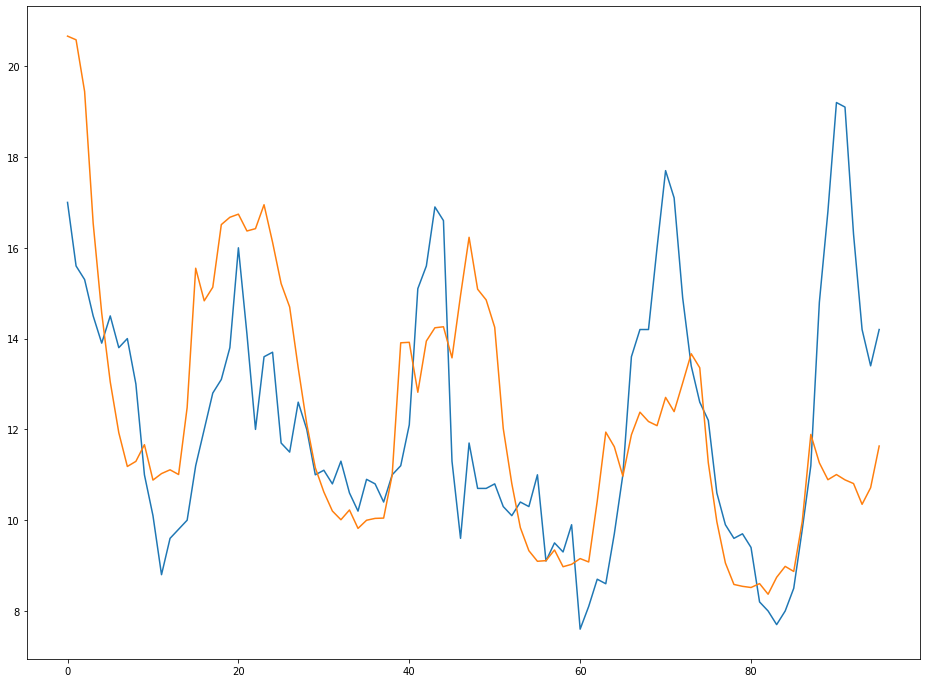

In [41]:
#for next season after training
start=12*24
end=16*24
test_true = dataset['T'][start:end].values

#if model selection has already been performed
exog_vals = None if mdl.exog is None else mdl.exog[start:end] 

#alternatively, one can re-run the function to get the exogenous variables
#exog_vals = mdl.generate_distributed_lags(exog=dataset[['exog1','exog2']][start:end],k=dl_param)

test_preds = fit_res.predict(n_periods=(end-start), X=exog_vals)
plt.plot(test_true)
plt.plot(test_preds)

In [42]:
skm.mean_absolute_percentage_error(test_endog, test_preds)

0.16428959131794243

In [43]:
mdl.best_params

[[3, 0, 0, 24]]

In [44]:
# Manually testing the best parameters using SARIMAX
#model = SARIMAX(dataset['gasoline'][:3*52], exog=dataset[['exog1','exog2']][:3*52], 
#                order=fit_res.order, seasonal_order=fit_res.seasonal_order)
#modelres = model.fit()
#modelres.summary()